In [1]:
# from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pandas as pd
import numpy as np
import scipy.optimize
import re
import os
import importlib

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter


import trmc.kin as kin
import trmc.load as load
import trmc.analysis as analysis
import trmc.plot as plot
from trmc.plot import exp_formatter

import xarray as xr

mpl.rcParams['figure.figsize'] = [8, 8]
mpl.rc('font',**{'size' : 18})

from IPython.display import clear_output

import itertools

from collections import OrderedDict

def dict_product(dicts):
    """
    >>> list(dict_product(dict(number=[1,2], character='ab')))
    [{'character': 'a', 'number': 1},
     {'character': 'a', 'number': 2},
     {'character': 'b', 'number': 1},
     {'character': 'b', 'number': 2}]
    """
    return (dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))

In [2]:
%store -r da_dv
%store -r da_bv
%store -r da_sw
%store -r da_dcs

C:\Users\coe_apirate\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


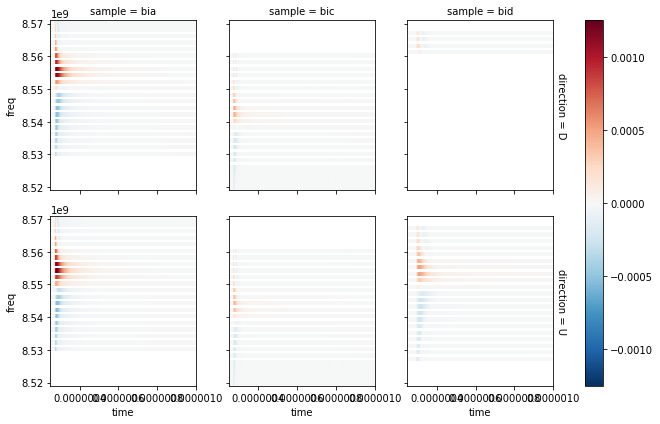

In [3]:
col = None if (len(da_dv.indexes['sample']) == 1)  else 'sample'
g = da_dv.dropna('fluence','all').mean('fluence').sel(time = slice(250e-9,1000e-9)).plot(x = 'time', y = 'freq', row = 'direction', col = col)
g

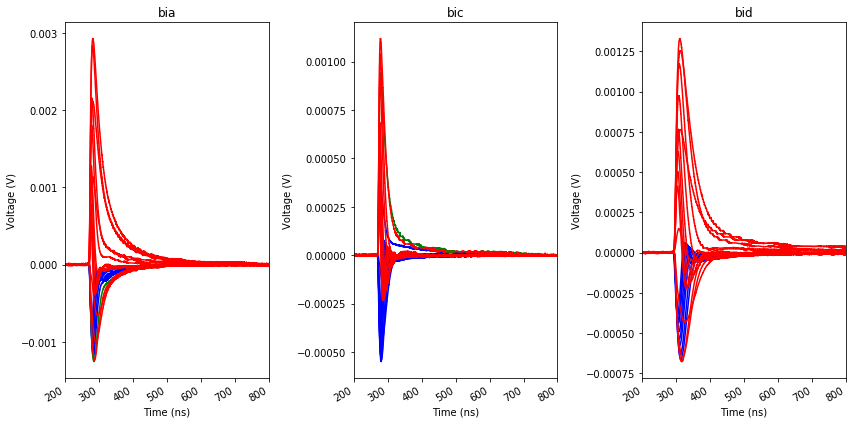

In [4]:
size = len(da_dv.indexes['sample'])
fig, axes = plt.subplots(1,size, figsize = (4*size, 2*size), squeeze=False)

for i,samp in enumerate(da_dv.indexes['sample']):
    data = da_dv.sel(sample = samp).sel(direction = 'U').dropna('fluence','all').isel(fluence = -1).dropna('time','all')
    ax = axes[0][i]
    f0 = 8.542e9
    ax = plot.redbluetransient(ax,data, f0)
    ax.set_title(samp)
    ax.set_xlim([200e-9,800e-9])

# ax.legend()
fig.autofmt_xdate()
fig.tight_layout()

## load in and plot the dark cavity sweeps

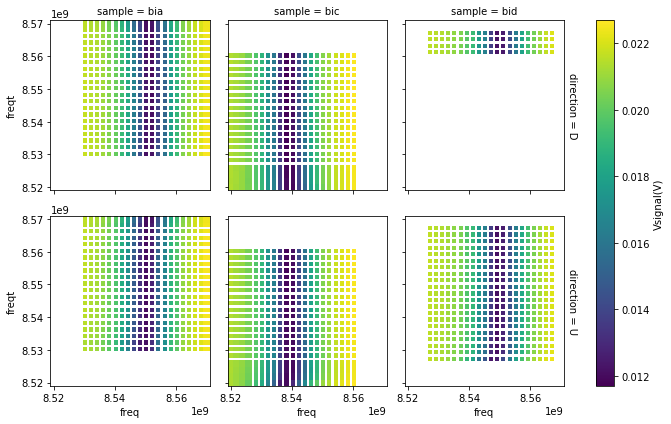

In [5]:
col = None if (len(da_dv.indexes['sample']) == 1)  else 'sample'
da_dcs.plot(x = 'freq',y='freqt',row = 'direction',col = col)

bia
bic
bid


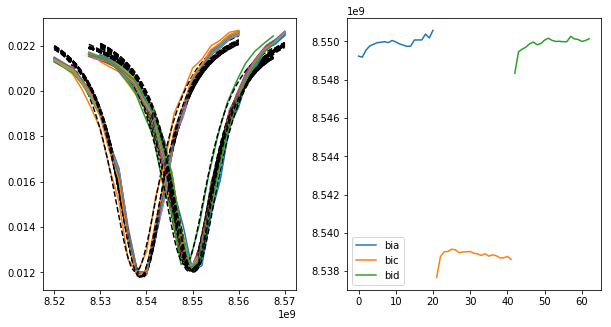

In [6]:
p_labels = ['f0','w','R','Rinf'] 
epsilon = 0.00001
bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
window = 100

fig, axes = plt.subplots(1,2, figsize = (10,5))

daf0s = []
for samp in da_dcs.indexes['sample']:
    print(samp)
    da = da_dcs.sel(sample = samp).sel(direction = 'U').dropna('freq','all').dropna('freqt','all')
    f0s = []
    for freqt in da.indexes['freqt']:
        d = da.sel(freqt = freqt)
        axes[0].plot(d.to_series())

        Rinf = 0.02125
        f0 = d.to_series().idxmin()
        p0 =[f0,1e7,0.01, Rinf]

        v0_fit, v0_p,v0_sl = analysis.fitsweep(d, p0, bounds, window , 'lor',p_labels)
        f0s.append(v0_p[0])

        freqs = da.indexes['freq']
        freqs_i = np.linspace(freqs.min(),freqs.max(),100)
        dfit = v0_fit(freqs_i)
        dfit = pd.Series(dfit, index = freqs_i)
        axes[0].plot(dfit, color = 'black', linestyle = '--')
    
    daf0s.append(xr.DataArray(f0s, coords = {'freqt' : da.indexes['freqt']}, dims= ['freqt']).assign_coords(sample = samp).expand_dims('sample'))


daf0s = xr.concat(daf0s, dim = 'freqt')

for samp in daf0s.indexes['sample']:
    axes[1].plot(daf0s.sel(sample = samp), label = samp)
    
axes[1].legend()

## Interpolate the dark cavity sweep to match with the delta v data array

In [7]:
da_dcsi = da_dcs.interpolate_na('freq').interpolate_na('freqt')
da_dcsi = da_dcsi.interp(freq = da_dv.indexes['freq'])

In [8]:
#method a: interpolate without interpna, by iterating over samples you can drop the na values. probably not important

# das = []
# for samp in da_dcs.indexes['sample']:

#     dcs = da_dcs.sel(sample = samp).dropna('freq','all').dropna('freqt','all')
#     dv = da_dv.sel(sample = samp).dropna('freq','all')#.dropna('fluence','all')

#     d = dcs.interp(freq = dv.indexes['freq'])
    
#     das.append(d)
    
# da_dcsi = xr.concat(das,dim = 'sample')

In [9]:
# For partial data sets, cut down the dark cavity sweep

# fmin = da_dv.indexes['freq'].min()
# fmax = da_dv.indexes['freq'].max()

# idxmin = abs(da_dcs.indexes['freq'] - fmin).argmin()
# idxmax = abs(da_dcs.indexes['freq'] - fmax).argmin() + 1 #???

#pull out a certian freqt from the data set for now...

For now just pull out one freqt

In [10]:
idx = 5
das = []
for samp in da_dcsi.indexes['sample']:
    freqt = da_dcsi.sel(sample = samp).dropna('freqt','all').indexes['freqt'][idx]
    das.append(da_dcsi.sel(sample = samp).sel(freqt = freqt).drop('freqt').dropna('freq','all'))
    
v0s = xr.concat(das, dim = 'sample')

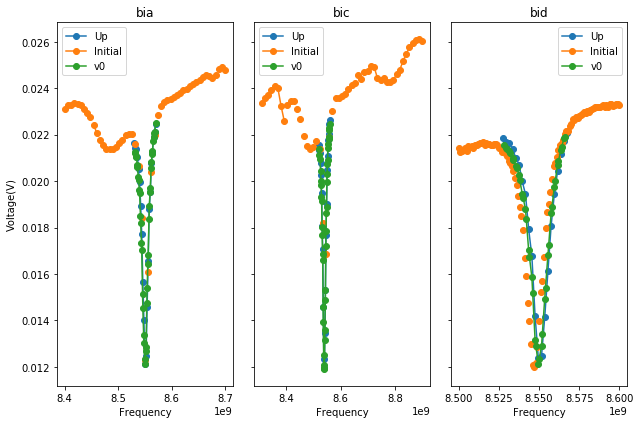

In [11]:
samples = da_bv.indexes['sample']
size = len(samples)
fig, axes = plt.subplots(1,size, figsize = (3*size,2*size) , sharey = True, squeeze=False)

for i, samp in enumerate(samples):
    swp_bv_u = da_bv.sel(sample = samp, direction = 'U').dropna('freq','all')
    axes[0][i].plot(swp_bv_u.indexes['freq'],swp_bv_u,marker = 'o', label = 'Up')
#     swp_bv_d = da_bv.sel(sample = samp, direction = 'D').dropna(dim = 'freq')
#     ax.plot(swp_bv_d.indexes['freq'],swp_bv_d,marker = 'o', label = 'Down')
    swp_init = da_sw.sel(sample = samp, tc = '_1_', swtime = 0)
    axes[0][i].plot(swp_init.indexes['freq'],swp_init,marker = 'o',label = 'Initial')
    v0= v0s.sel(sample = samp,direction = 'U').dropna('freq','all')
    axes[0][i].plot(v0.to_series(),marker = 'o',label = 'v0')
    axes[0][i].set_title(samp)
    axes[0][i].legend()
    axes[0][i].set_xlabel('Frequency')
    axes[0][0].set_ylabel('Voltage(V)') 

    fig.tight_layout()

## fitting setup

Define fit parameters

In [12]:
fittype = 'lor'
# fittype = 'poly'

if fittype == 'lor':
    Rinf = 0.02125
    f0 = None
    p0 =[f0,1e7,0.01, Rinf]
    p_labels = ['f0','w','R','Rinf'] 
    epsilon = 0.001
#     bounds = ([0,0,0, Rinf - epsilon],[np.inf,np.inf,np.inf, Rinf + epsilon])
    bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
    window = 100

elif fittype == 'poly':
    window = 2
    p_labels = ['R', 'f0', 'p0','p1','p2']
    bounds = ([-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf])
    p0 = [.01,1e-9,1e-18]
    

time1 = 200e-9
time2 = 850e-9
step = 100 #not index and has been moved inside for loop...need to check

times = da_dv.indexes['time']
timesel1 = pd.Series(abs(times-time1)).idxmin()
timesel2 = pd.Series(abs(times-time2)).idxmin()

times = times[slice(timesel1,timesel2)]

direcs = ['U']
# samps = v0s.indexes['sample']
samps = ['bia','bid','bic']
flus = slice(-1,-5,-1)
seldicts = list(dict_product({'sample' :samps, 'direction':direcs}))


Initialize data and perform fits

In [13]:
#Setup dictionaries to input paramters into
da_p = da_dv.isel(freq = 0).drop('freq').where(False).copy()
da_p0 = da_dcs.isel(freqt = 0).drop('freqt').isel(freq = 0).drop('freq').where(False).copy()

da_p_dict = {}
da_p0_dict = {}
for p in p_labels:
    da_p_dict[p] = da_p
    da_p0_dict[p] = da_p0
    
#Not exactly sure why I have to do this copying. Otherwise I think the reference to the original numpy array is kept and assignments get all weird
ds_p = xr.Dataset(da_p_dict).copy(deep=True)
ds_p0 = xr.Dataset(da_p0_dict).copy(deep=True)

fits_v0 = v0s.copy(deep= True).where(False)
Ks = pd.Series(index = samps)

ds_p_r  =  ds_p.sel(time = times).copy(deep = True).where(False)   #nessecary, subselection is currently not done for ds_p0
dvs = da_dv.sel(time = times)
vss = v0s + dvs
fits = vss.copy(deep = True).where(False)

num = len(seldicts)*(abs(flus.stop - flus.start))

### FITTING
i=0
for seldict in seldicts:
    clear_output(wait = True)
    
    ### V0 fitting
    v0 = v0s.sel(seldict).dropna('freq','all')
    samp = seldict['sample']
    direc = seldict['direction']
    
    p0[0] = None
    v0_fit, v0_p,v0_sl = analysis.fitsweep(v0, p0, bounds, window , fittype,p_labels)
    freqs = v0s.indexes['freq'][v0_sl]
    fits_v0.loc[samp,direc] = v0_fit(freqs)

    for j, p in enumerate(ds_p0.data_vars):
        ds_p0[p].loc[samp,direc] = v0_p[j]
    
    Ks[samp] = analysis.calc_K(f0 = v0_p[0], w = v0_p[1], R0 = v0_p[2]/v0_p[3], printparams = False)
    print('K sample ' + samp + ' = ' + str(Ks.loc[samp]))
    
    ###Time Series fitting
    
    vs1 = vss.sel(seldict).dropna('fluence','all').dropna('freq','all').dropna('time','all')
    for flu in vs1.indexes['fluence'][flus]:
        vs2 = vs1.sel(fluence = flu)
        i=i+1
        
        print(str((i/num)*100.0) + ' %') #Not sure where this factor of 3 is coming from, see num above. 
        for time in vs2.indexes['time'][::100]:
            vs3 = vs2.dropna('freq','all').sel(time = time)
            
            p0[0] = None
            vs_fit, vs_p,vs_sl = analysis.fitsweep(vs3, p0, bounds, window , fittype,p_labels)

            freqs = vss.indexes['freq'][vs_sl]
            fits.loc[samp,direc,:,flu,time] = vs_fit(freqs).values
            ds_p_r['f0'].loc[samp,direc,flu,time] = vs_p[0]
            ds_p_r['w'].loc[samp,direc,flu,time] = vs_p[1]
            ds_p_r['R'].loc[samp,direc,flu,time] = vs_p[2]
            ds_p_r['Rinf'].loc[samp,direc,flu,time] = vs_p[3]
                    
fits.name = 'fits'
dvs.name = 'dvs'
vss.name = 'vss'
            
das = [dvs,fits,vss]
ds = xr.merge(das)
print('done')

K sample bic = 74202.50050752185
75.0 %
83.33333333333334 %
91.66666666666666 %
100.0 %
done


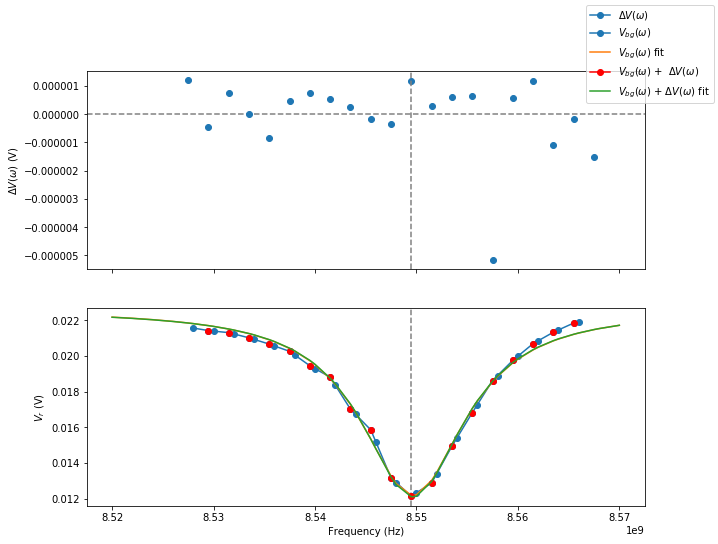

interactive(children=(FloatSlider(value=525.0, description='timesel', max=850.0, min=200.0, step=1.0), Output(…

In [14]:
# %matplotlib ipympl

samp = 'bid'

dst = ds.sel(sample = samp).sel(direction = 'U').drop('direction') #try drop any fluence nan...

dv = dst['dvs'].dropna('fluence','all').isel(fluence = -1).isel(time = 0)
fit = dst['fits'].dropna('fluence','all').isel(fluence = -1).isel(time = 0)
vs = dst['vss'].dropna('fluence','all').isel(fluence = -1).isel(time = 0)

v0 = v0s.sel(sample = samp).sel(direction = 'U').drop('direction').dropna('freq','all')
fit_v0 = fits_v0.loc[samp].sel(direction = 'U').drop('direction').dropna('freq','all')

times = dst['vss'].dropna('time','all').indexes['time']
# sample = vss.sample.values
# timesel = min(times, key=lambda x:abs(x-timesel))

fig, axes, lns = plot.vsplotxr(dv, vs = vs, fit = fit, v0 = v0, fit_v0 = fit_v0, plotkwargs={'figsize' : (10,8)})

# axes[0].set_ylim([-2e-3,3e-3])

def inter_vsplot(timesel,dst,lns,fig):
    timesel = timesel*1e-9
    timesel = min(times, key=lambda x:abs(x-timesel))
    
    for name in lns.index:
        l = lns[name][0]
        l.set_ydata(dst[name].dropna('fluence','all').isel(fluence = -1).sel(time = timesel))
        
#     fig.suptitle('$\Delta V(\omega)$ taken at ' + str(timesel) + 's for sample ' + str(sample))
    fig.canvas.draw()
    
interact(inter_vsplot, timesel=(time1*1e9,time2*1e9,1),dst = fixed(dst),lns = fixed(lns), fig = fixed(fig));

In [15]:
#plot.sweepfitanim(dst, interval = 100)   # Not currently working

In [16]:
%matplotlib inline

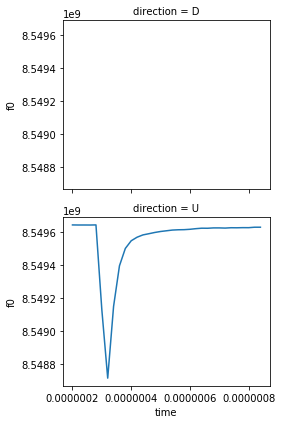

In [17]:
ds_p_r.sel(sample = 'bid').dropna('time','all').dropna('fluence','all').isel(fluence = -1)['f0'].plot(row ='direction')

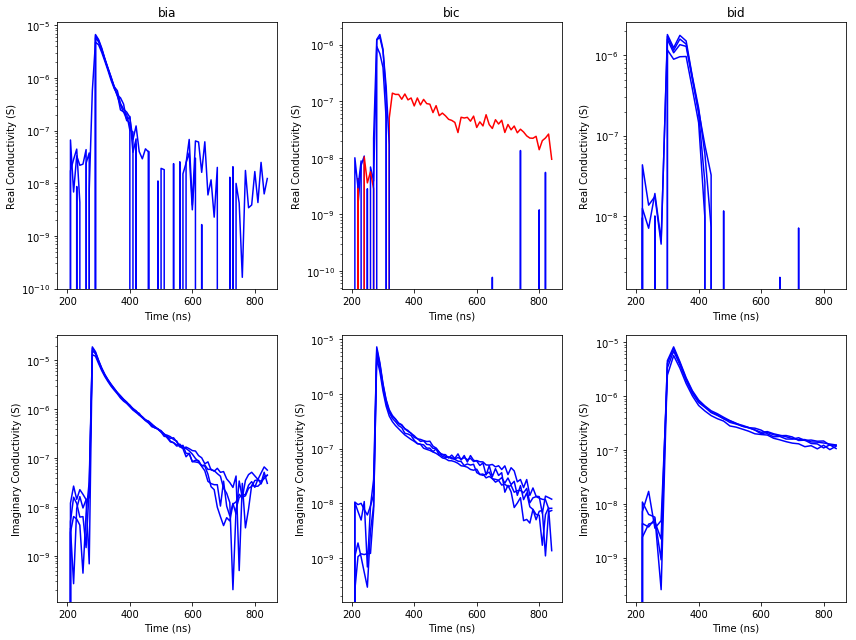

In [18]:
fig, axes = plt.subplots(2,len(ds.indexes['sample']), figsize = (12,9), squeeze = False)
# axes= [axes]
e0 = 8.854e-12
F=1

ft = ds_p_r['f0'].sel(direction ='U')
f0 = ft.isel(time = 0)
deltaf = abs(ft-f0)
sig_I_a = -1*deltaf*e0/F

wt = ds_p_r['w'].sel(direction ='U')
w0 = wt.isel(time = 0)
deltaFWHM = wt - w0
sig_R_a = deltaFWHM*e0/(2*F)


for i , samp in enumerate(ds_p_r.indexes['sample']):
    sig_Rs = sig_R_a.sel(sample = samp).dropna('fluence','all').dropna('time','all').copy(deep = True)
    sig_Is = sig_I_a.sel(sample = samp).dropna('fluence','all').dropna('time','all').copy(deep = True)
    for fluence in sig_Rs.indexes['fluence']:
        sig_R = sig_Rs.sel(fluence = fluence)
        sig_I = sig_Is.sel(fluence = fluence)

        label = '$\sigma^{\'}(\Delta FWHM)$'

        ax = axes[0][i]
        sig_R = sig_R.to_series()
        if np.trapz(sig_R) < 0:
            color = 'b'
            sig_R = sig_R*-1
        else:
            color = 'r'
        ax.plot(sig_R, label = label, color = color)
        ax.set_yscale('log')
        ax.set_ylabel('Real Conductivity (S)')

        ax = axes[1][i]
        sig_I = sig_I.to_series()
        if np.trapz(sig_I) < 0:
            color = 'b'
            sig_I = sig_I*-1
        else:
            color = 'r'
        ax.plot(sig_I, label = '$\sigma^{\'\'}(\Delta\omega)$', color = color)
        ax.set_yscale('log')
        ax.set_ylabel('Imaginary Conductivity (S)')

    ax = axes[0][i]
    ax.set_title(samp)
for axs in axes:
    for ax in axs:
    #     for ax in axs:
        ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    #         axes.set_xlim(250e-9,1200e-9)
        ax.set_xlabel('Time (ns)')

        # axes.set_ylim([1e-8,1e-4])

fig.tight_layout()

In [19]:
ratio = sig_R_a/sig_I_a

In [20]:
def dropna_fg(g):
    """drops na for traces on a facet grid"""
    for ax in g.axes[0]:
        lns = ax.lines
        for ln in lns:
            d = ln.get_data()
            s = pd.Series(d[1],index = d[0]).dropna()
            ln.set_data([s.index,s.values])

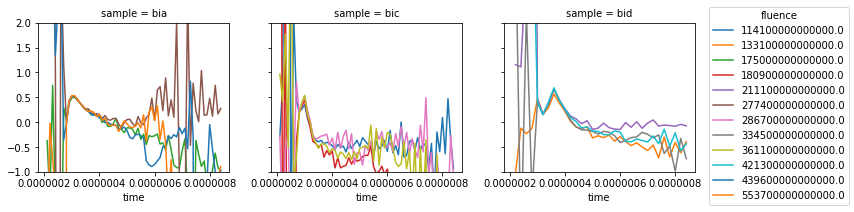

In [21]:
g = ratio.dropna('fluence','all').plot(x='time',hue = 'fluence',col = 'sample')

dropna_fg(g)

for ax in g.axes[0]:
    ax.set_ylim([-1,2])


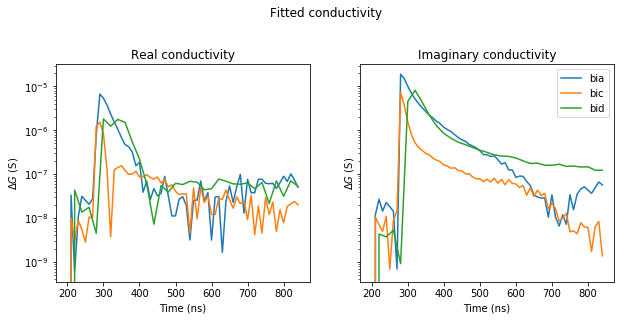

In [22]:
# res = g.sel(freq = 8.5420e9, method = 'nearest')

fig, axes = plt.subplots(1,2, figsize = (10,4), sharey = True)

for sample in ds.indexes['sample']:
    sel = sig_R_a.sel(sample = sample).dropna('fluence','all').dropna('time','all').isel(fluence = -1)
    axes[0].plot(abs(sel.to_series()), label = sample)
    axes[0].set_title('Real conductivity')
    sel = sig_I_a.sel(sample = sample).dropna('fluence','all').dropna('time','all').isel(fluence = -1)
    axes[1].plot(abs(sel.to_series()), label = sample)
    axes[1].set_title('Imaginary conductivity')

for ax in axes:
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('$\Delta G$ (S)')
        
        
fig.suptitle('Fitted conductivity', y = 1.08)
ax.legend()

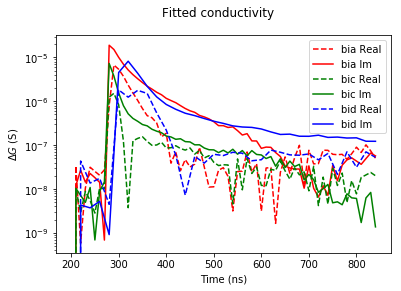

In [23]:
# res = g.sel(freq = 8.5420e9, method = 'nearest')

fig, ax = plt.subplots()

colors = ['r','g','b']

for i, sample in enumerate(ds.indexes['sample']):
    sigr = sig_R_a.sel(sample = sample).dropna('fluence','all').dropna('time','all').isel(fluence = -1)
    sigi = sig_I_a.sel(sample = sample).dropna('fluence','all').dropna('time','all').isel(fluence = -1)
    ax.plot(abs(sigr.to_series()), label = sample + " Real", linestyle = '--', color = colors[i])
    ax.plot(abs(sigi.to_series()), label = sample + " Im", color = colors[i])    
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
        
ax.set_xlabel('Time (ns)')
ax.set_ylabel('$\Delta G$ (S)')
        
fig.suptitle('Fitted conductivity')
ax.legend()